## Setup and get data ##

In [36]:
import os, time, uuid, cv2
import shutil
import random
def PRINT() -> None: print('-'*80)

In [3]:
IMAGES_PATH = os.path.join('data', 'images')
NUMBER_IMGS = 30

In [4]:
def count_images_in_directory(directory_path):
    """

    """
    
    files = os.listdir(directory_path)
    image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]
    return len(image_files)

In [12]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()

    # Take single image sample by pressing on the 't' key
    if cv2.waitKey(1) & 0xFF == ord('t'):
        imgname = os.path.join(IMAGES_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & count_images_in_directory(IMAGES_PATH) == NUMBER_IMGS:
        print(f'Total number of collected images -> {count_images_in_directory(IMAGES_PATH)}')
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

Total number of collected images -> 30


In [65]:
!labeleme

'labeleme' is not recognized as an internal or external command,
operable program or batch file.


## Visualize the dataset and buil image loading function ##

### Impor libraries ###

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### Load image  into TF data pipeline ###

In [37]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [38]:
images.as_numpy_iterator().next() # Single image path

b'data\\images\\00cc693a-9023-11ee-94d3-646c8087a76e.jpg'

In [39]:
def load_image(image_path):
    """
    
    """
    byte_img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(byte_img)
    
    return img

In [40]:
images = images.map(load_image)

In [41]:
images.as_numpy_iterator().next() # Actual image

array([[[193, 182, 176],
        [194, 183, 177],
        [192, 181, 175],
        ...,
        [179, 169, 168],
        [176, 166, 167],
        [178, 168, 169]],

       [[195, 184, 178],
        [195, 184, 178],
        [194, 183, 177],
        ...,
        [181, 171, 170],
        [176, 166, 167],
        [177, 167, 168]],

       [[196, 187, 182],
        [196, 187, 182],
        [195, 186, 181],
        ...,
        [178, 169, 170],
        [176, 167, 170],
        [177, 168, 171]],

       ...,

       [[ 49,  73,  83],
        [ 47,  71,  81],
        [ 47,  69,  80],
        ...,
        [ 25,  25,  35],
        [ 29,  29,  39],
        [ 29,  29,  39]],

       [[ 48,  75,  86],
        [ 45,  72,  81],
        [ 45,  69,  79],
        ...,
        [ 22,  25,  34],
        [ 25,  28,  37],
        [ 26,  29,  38]],

       [[ 48,  75,  86],
        [ 45,  72,  83],
        [ 45,  69,  79],
        ...,
        [ 21,  24,  33],
        [ 25,  28,  37],
        [ 26,  29,  38]]

In [42]:
type(images) # verify the type of our images dataset

tensorflow.python.data.ops.map_op._MapDataset

### Visualize raw images using matplotlib ###

In [43]:
image_generator = images.batch(4).as_numpy_iterator()

In [44]:
plot_images = image_generator.next()

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

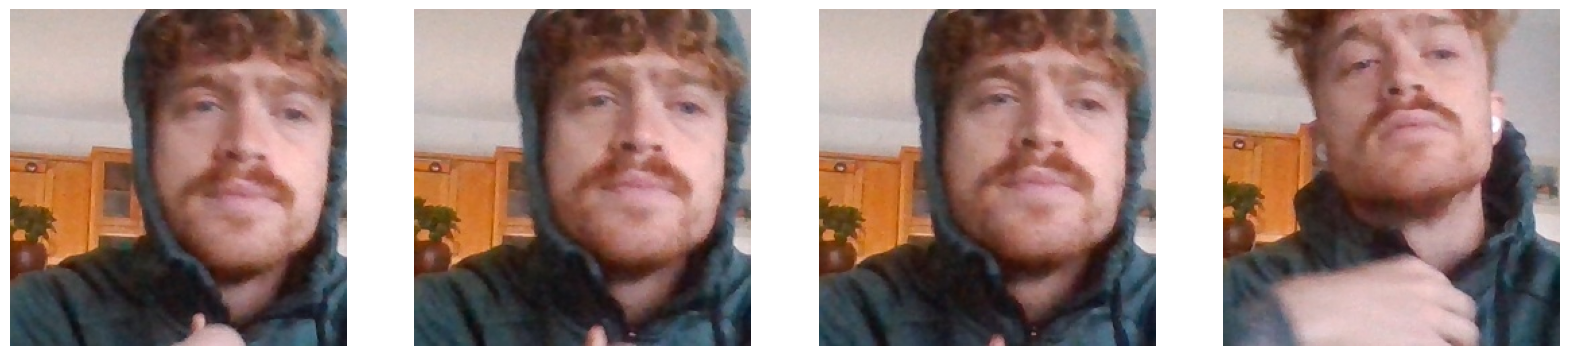

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(plot_images):
    ax[idx].imshow(img)
    ax[idx].axis(False)

plt.imshow

## Partition unagmented data ##

In [46]:
base_dir = 'data\\'
split_dirs = ['train', 'test', 'val']

# Create directory structure
for split_dir in split_dirs:
    split_path = os.path.join(base_dir, split_dir)
    for subdir in ['images', 'labels']:
        os.makedirs(os.path.join(split_path, subdir), exist_ok=True)

PRINT()
print("Directory structure created successfully.")
PRINT()

--------------------------------------------------------------------------------
Directory structure created successfully.
--------------------------------------------------------------------------------


## Partition unagmented data ##

In [12]:
def split_data(src_dir, dest_train_dir, dest_val_dir, dest_test_dir, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    # Get the list of all files in the source directory
    all_files = os.listdir(src_dir)
    total_files = len(all_files)

    # Calculate the number of files for each split
    num_train = int(total_files * train_ratio)
    num_val = int(total_files * val_ratio)
    num_test = total_files - num_train - num_val

    # Shuffle the list of files
    random.shuffle(all_files)

    # Split the files into train, validation, and test sets
    train_files = all_files[:num_train]
    val_files = all_files[num_train:num_train + num_val]
    test_files = all_files[num_train + num_val:]

    # Move the files to their respective directories
    move_files(src_dir, dest_train_dir, train_files)
    move_files(src_dir, dest_val_dir, val_files)
    move_files(src_dir, dest_test_dir, test_files)

In [13]:
def move_files(src_dir, dest_dir, file_list):
    os.makedirs(dest_dir, exist_ok=True)
    for file_name in file_list:
        src_path = os.path.join(src_dir, file_name)
        dest_path = os.path.join(dest_dir, file_name)
        shutil.move(src_path, dest_path)

In [14]:
src_directory = 'data\\images'
train_directory = 'data\\train\\images'
val_directory = 'data\\val\\images'
test_directory = 'data\\test\\images'

In [15]:
split_data(src_directory, train_directory, val_directory, test_directory)

### Move the matching labels to the correct images folder ###

In [16]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

## Apply image augmentation techniques ##

In [74]:
import albumentations as alb

In [75]:
augmentor = alb.Compose([
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

### Test the data augmentation on random image ##

In [76]:
img = cv2.imread(os.path.join('data','images','00d63fd5-9023-11ee-8490-646c8087a76e.jpg'))

In [77]:
with open(os.path.join('data','labels','00d63fd5-9023-11ee-8490-646c8087a76e.json'), 'r') as f:
    label = json.load(f)

In [78]:
type(label)

dict

In [79]:
label['shapes'][0]['points']

[[85.5654761904762, 8.333333333333334],
 [222.17261904761904, 172.02380952380955]]

### Extract coordinates and rescale to match image resolution ###

In [80]:
coords = [point for shape in label['shapes'] for points in shape['points'] for point in points]

In [81]:
PRINT()
print(f"The coordinates of the test image we got are : \n\n{coords}") 
PRINT()

--------------------------------------------------------------------------------
The coordinates of the test image we got are : 

[85.5654761904762, 8.333333333333334, 222.17261904761904, 172.02380952380955]
--------------------------------------------------------------------------------


In [82]:
coords = list(np.divide(coords, [640,480,640,480]))

In [83]:
PRINT()
print(f"The transformed coordinates of the test image we got are : \n\n{coords}") 
PRINT()

--------------------------------------------------------------------------------
The transformed coordinates of the test image we got are : 

[0.13369605654761907, 0.017361111111111112, 0.34714471726190477, 0.35838293650793657]
--------------------------------------------------------------------------------


### Apply augmentation techniques and visualize ###

In [84]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Face'])

In [85]:
augmented['bboxes'][0][2:]

(0.8663039434523809, 0.35838293650793657)

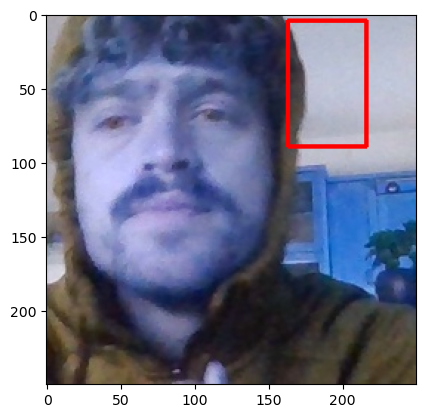

In [86]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [250,250]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [250,250]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [35]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            for face_idx, face in enumerate(label['shapes']):
                coords = [face['points'][0][0], face['points'][0][1], face['points'][1][0], face['points'][1][1]]
                coords = list(np.divide(coords, [640, 480, 640, 480]))

                try:
                    for x in range(60):
                        augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                        cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}_face{face_idx}_{x}.jpg'), augmented['image'])

                        annotation = {}
                        annotation['image'] = image

                        if len(augmented['bboxes']) == 0:
                            annotation['bbox'] = [0, 0, 0, 0]
                            annotation['class'] = 0
                        else:
                            annotation['bbox'] = augmented['bboxes'][0]
                            annotation['class'] = 1

                        with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}_face{face_idx}_{x}.json'), 'w') as f:
                            json.dump(annotation, f)

                except Exception as e:
                    print(e)


Expected x_min for bbox [1.2748991935483869, 3.088575268817204, 1.3807459677419351, 3.216263440860215, 'face'] to be in the range [0.0, 1.0], got 1.2748991935483869.
Expected x_min for bbox [1.400907258064516, 3.0079301075268816, 1.5168346774193544, 3.135618279569892, 'face'] to be in the range [0.0, 1.0], got 1.400907258064516.
Expected x_min for bbox [4.273891129032258, 4.365456989247312, 4.667036290322581, 4.82244623655914, 'face'] to be in the range [0.0, 1.0], got 4.273891129032258.
Expected x_min for bbox [2.3650815217391306, 3.233876811594203, 2.8066576086956525, 3.8317028985507244, 'face'] to be in the range [0.0, 1.0], got 2.3650815217391306.
Expected x_min for bbox [2.4805706521739133, 3.2429347826086956, 2.956114130434783, 3.704891304347826, 'face'] to be in the range [0.0, 1.0], got 2.4805706521739133.
Expected x_min for bbox [2.2767663043478263, 4.184963768115941, 2.5077445652173913, 4.43858695652174, 'face'] to be in the range [0.0, 1.0], got 2.2767663043478263.
Expected 